[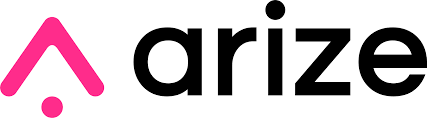](https://arize.com)

# Evaluator Prompt Optimization

In this notebook we'll be using the Prompt Learning SDK to optimize an LLM-as-Judge Eval Prompt. LLM-as-Judge evaluators use an LLM to evaluate LLM outputs, and are effective and versatile in testing/evaluating your LLM applications. You can learn more [here](https://arize.com/llm-as-a-judge/).

Since your evals use LLMs, the prompts you provide to those LLMs dictate what your eval does. In practice, the goal is to ALIGN your eval with your goals. You want to bring your eval to a level of competence that you would expect from a human who manually evaluates outputs.

This notebook shows you how to build an evaluator that checks if outputs are normalized/sanitized, and then align the evaluator with your expectations for normalization/sanitization so you can trust this eval in production by optimizing its prompt. 

[Learn more about Arize Prompt Learning here.](https://arize.com/blog/prompt-learning-using-english-feedback-to-optimize-llm-systems/)

In [ ]:
%pip install -q "arize-phoenix-evals>=2.0.0" arize-phoenix openai pandas

In [10]:
import sys, os, getpass
import pandas as pd
import nest_asyncio
from phoenix.evals import llm_generate, OpenAIModel
import warnings
nest_asyncio.apply()

In [11]:
os.environ['OPENAI_API_KEY'] = os.environ['OPENAI_API_KEY'] or getpass.getpass('OpenAI API Key:')

# BizNorm-100 Benchmark

BizNorm-100 is a synthetically created dataset containing 100 queries. The goal is to normalize these queries with respect to certain ruleset. 

For example, the query

```My card 3333-4444-5555-6666 was charged $1200 on 1/12/2025. The record still shows my old phone, 646-555-2201, and the system emailed the receipt to anthony.rogers@company.org. Can you fix this ASAP?```

should be normalized to

```[PII ALERT] My card [CARD] was charged usd 1200.00 on 2025-01-12. The record still shows my old phone, [PHONE], and the system emailed the receipt to [EMAIL]. Can you fix this as soon as possible? -- Company Confidential --```

**See the normalization ruleset in BizNorm-ruleset.md.**

## Train/Test Split

We will be using the training set to train our evaluator with Prompt Learning.
We will be using the test set to test our evaluator's accuracy on data it has not been trained on.

In [12]:
BizNorm_100 = pd.read_csv("../datasets/BizNorm-100.csv")
train = BizNorm_100.sample(frac=0.7, random_state=42)
test = BizNorm_100.drop(train.index)

## Application System Prompt

This is the application system prompt, or the prompt to the LLM used to generate outputs.

This is **NOT** the prompt we are optimizing! This simply generates outputs. 

We are optimizing the **evaluator prompt**, or the prompt for the LLM-as-judge eval which EVALUATES the generated outputs. 

In [7]:
# NOT the prompt we are optimizing
system_prompt = """
You are a helpful assistant that assists in normalizing text. Your task is to normalize the text based on the following rules:

Replace any email address with [EMAIL].
Replace any Social Security–like number (###-##-####) with [SSN].
If a person’s full name (two capitalized words) appears, replace with [NAME].
Normalize percentages (e.g., 15%, 15 percent) → 0.15.
If a number is over 1000, and contains commas, remove the commas (10,000 → 10000).
Remove extra whitespace and replace with a single space.
Replace slang like u → you, thx → thanks, pls → please.
If a message contains banned words (e.g., refund, lawsuit, fraud), replace them with [FLAGGED].
Append a compliance footer: -- Company Confidential -- at the end of every message.

Here is the original text: {query}
Return just the normalized text, no other text.
"""

## Output Generator
Uses the application system prompt to generate outputs.

In [6]:
def generate_output(dataset, system_prompt):
    model = OpenAIModel(
        model="gpt-4o-mini-2024-07-18",
        model_kwargs={
            "temperature": 0
        }
    )
    outputs = llm_generate(
        dataframe=dataset,
        template=system_prompt,
        model=model,
        concurrency=40,
    )
    return outputs["output"]

## Sanitization Helpers

clean and clean_series are used to normalize text before comparing generated outputs with ground truths. This prevents false mismatches caused by superficial formatting differences.

For example, the string:

```"today's year is 1/1/2025"```


might be normalized to:

```"today's year is 2025-01-01"```


If we compare it against a ground truth like:

```"today’s year is 2025-01-01"```


a raw string comparison would incorrectly flag them as different because of the straight vs. curly apostrophe. Normalization ensures both strings are treated as equivalent, so the comparison is judged correctly.

In [5]:
import unicodedata

def clean(label):
    if pd.isna(label):
        return ""
    label = str(label)
    # map curly/smart quotes → straight quotes
    smart_map = {
        ord('‘'): "'",
        ord('’'): "'",
        ord('‚'): "'",
        ord('‛'): "'",
        ord('“'): '"',
        ord('”'): '"',
        ord('„'): '"',
        ord('‟'): '"',
    }
    # normalize Unicode width/compatibility, apply smart_map, strip + lower
    cleaned = unicodedata.normalize('NFKC', label).translate(smart_map)
    return cleaned.strip().strip('"').strip("'").lower()

clean_series = lambda s: s.astype(str).apply(clean)

## Accuracy Computation

Computes accuracy, f1, precision, recall.

In [4]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def compute_accuracy(y_pred, y_true):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        y_pred = [clean(label) for label in y_pred]
        y_true = [clean(label) for label in y_true]
        return accuracy_score(y_true, y_pred)

## Evaluator

This is the code for our LLM-as-Judge evaluator.

It checks whether outputs are normalized properly.

You can see the prompt below. THIS IS THE PROMPT WE ARE OPTIMIZING. 

We want to build evals that align with how we expect them to perform. Good evals are very important. They allow you to filter and classify the information you feed to your users. Because LLM outputs are not deterministic, you need something to check those outputs. It's too time consuminng to do this manually, so employing an LLM to evaluate these outputs is a common and essential practice. 

In [ ]:
import re
from phoenix.evals.llm import LLM
from phoenix.evals import ClassificationEvaluator, evaluate_dataframe, create_evaluator

evaluator_prompt = """

You are a helpful assistant that evaluates normalized text. Your task is to evaluate whether the text redacts secure information and normalizes any numbers properly.
If secure information is redacted and numbers are normalized properly, return "correct". Otherwise, return "incorrect".

Here is the original text: {query}
Here is the normalized text: {output}
Return in JSON format with the following 2 fields:
explanation: Brief explanation of why the normalized text is correct (normalized properly) or incorrect (normalized incorrectly), referencing the correct label if relevant.
correctness: "correct" or "incorrect".
"""

def evaluate_output(dataset, evaluator_prompt):
    llm = LLM(provider="openai", model="gpt-4o")

    evaluator = ClassificationEvaluator(
        "sanity_checker",
        llm,
        evaluator_prompt,
        choices={
            "correct": 1,
            "incorrect": 0
        }
    )
    evaluation_results = evaluate_dataframe(
        dataset,
        [evaluator]
    )["sanity_checker_score"]

    evaluation_results = pd.DataFrame(
        evaluation_results.apply(json.loads).tolist(),
        index=evaluation_results.index
    )

    return evaluation_results["label"], evaluation_results["explanation"]

## Generate Output and Evaluate

This combines our output generator and our evaluator into one function, and also computes accuracies for our outputs and also our evaluator.

Evaluator accuracy is computed by comparing what the eval thinks ("correct" or "incorrect") versus whether the output is equal to the ground truth or not (actual "correct" or "incorrect").

In [14]:
def generate_output_and_evaluate(dataset, system_prompt, evaluator_prompt):
    dataset["output"] = generate_output(dataset, system_prompt)
    dataset_accuracy = compute_accuracy(dataset["output"], dataset["ground_truth"])
    dataset["eval_ground_truth"] = ["correct" if clean(row["ground_truth"]) == clean(row["output"]) else "incorrect" for _, row in dataset.iterrows()]
    dataset["eval"], dataset["eval_explanation"] = evaluate_output(dataset, evaluator_prompt)
    dataset_evaluator_accuracy = compute_accuracy(dataset["eval"], dataset["eval_ground_truth"])
    return dataset, dataset_accuracy, dataset_evaluator_accuracy

### Run this below cell!

In [ ]:
# Add parent directory to path
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

## Helper Function - calling the Prompt Learning SDK

You can see the `optimize_iteration` helper function here actually initializes the optimizer with feedback and produces a new, optimized prompt. 

**The next step is figuring out what feedback to provide to the optimizer in order for it to generate optimized prompts.**

In [ ]:

from optimizer_sdk.prompt_learning_optimizer import PromptLearningOptimizer

def test_evaluator_performance(train, test, system_prompt, evaluator_prompt):
    train, train_accuracy, train_evaluator_accuracy = generate_output_and_evaluate(
        train, system_prompt, evaluator_prompt
    )
    test, test_accuracy, test_evaluator_accuracy = generate_output_and_evaluate(
        test, system_prompt, evaluator_prompt
    )
    return train, test, train_evaluator_accuracy, test_evaluator_accuracy

def optimize_iteration(feedback_set, feedback_columns, evaluator_prompt):
    optimizer = PromptLearningOptimizer(
        prompt=evaluator_prompt,
        model_choice="o3-2025-04-16",
        openai_api_key=os.getenv("OPENAI_API_KEY")
    )

    evaluator_prompt = optimizer.optimize(
        feedback_set,
        "eval",
        feedback_columns=feedback_columns,
        context_size_k=90000,
    )
    return evaluator_prompt


# 🔄 Optimization Workflow using Prompt Learning

This notebook implements an **interactive optimization loop** where we:
1. **Collect Feedback** — Display examples from the dataset, and let the user label correctness/explanations.
2. **Optimize Prompt** — Use the feedback to generate an updated evaluator prompt.
3. **Review & Confirm** — Show the optimized prompt, allow manual edits for formatting, and confirm it.
4. **Evaluate** — Re-run the evaluator with the new prompt on train/test sets, log metrics, and save results.
5. **Loop** — Repeat the cycle for `N` rounds, carrying forward the updated evaluator prompt and re-evaluated outputs.

The feedback we provide to the Prompt Learning optimizer is HUMAN ANNOTATED FEEDBACK. We show the power of just needing to annotate 5 examples per loop, and seeing optimization boosts! This shows the data efficiency of Prompt Learning. Rather than RL or an programmatic optimizer, where you need lots of data to make effective accuracy boosts, just hand annotating 5 outputs and giving that feedback to Prompt Learning allows for huge boosts in accuracy.

The workflow is composed of modular helper functions:

- `collect_feedback_ui`: interactive widget interface for gathering manual feedback.  
- `review_and_confirm_prompt`: UI for reviewing and editing the optimized prompt before saving.  
- `run_one_round`: runs a single loop round (feedback → optimize → confirm → evaluate).  
- `interactive_optimization_loop`: orchestrates the full multi-round optimization process.  


## 📝 `collect_feedback_ui`

This function creates an **interactive feedback form** using `ipywidgets`:

- Displays a sample of `query`, `ground_truth`, `output`, and evaluator outputs.
- Provides dropdowns / textareas for feedback fields (`evaluator_correctness`, `evaluator_explanation`).
- Saves the annotated feedback set (`feedback_set`) to CSV.
- Calls `on_save(feedback_set)` after the user clicks **Save Feedback**, triggering the next step in the workflow.

In [ ]:
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets

def collect_feedback_ui(feedback_set, feedback_columns, on_save):
    """
    Display feedback UI for a batch of examples.
    Calls `on_save(feedback_set)` when user saves.
    """
    
    all_widgets = []

    display(HTML("<h3>Manual Feedback Collection</h3>"))
    for idx, row in feedback_set.iterrows():
        example_html = f"""
        <div style="border: 1px solid #ddd; padding: 15px; margin: 10px 0; border-radius: 5px; background-color: #f9f9f9;">
            <h4>Example {idx + 1}</h4>
            <p><b>Query:</b><br>{row['query']}</p>
            <p><b>Ground Truth:</b><br>{row['ground_truth']}</p>
            <p><b>Generated Output:</b><br>{row['output']}</p>
            <p><b>Evaluation:</b><br>{row['eval']}</p>
            <p><b>Evaluation Explanation:</b><br>{row['eval_explanation']}</p>
        </div>
        """
        display(widgets.HTML(value=example_html))

        feedback_widgets = {}
        for col in feedback_columns:
            if "correctness" in col:
                widget = widgets.Dropdown(
                    options=['correct', 'incorrect'],
                    description=col,
                    style={'description_width': '150px'},
                    layout=widgets.Layout(width='300px')
                )
            else:
                widget = widgets.Textarea(
                    description=col,
                    placeholder=f'Enter {col}...',
                    style={'description_width': '150px'},
                    layout=widgets.Layout(width='500px', height='80px')
                )
            display(widget)
            feedback_widgets[col] = widget

        all_widgets.append((idx, feedback_widgets))
        display(HTML("<hr>"))

    save_btn = widgets.Button(description="💾 Save Feedback", button_style="success")
    output = widgets.Output()

    def _save(_):
        for idx, widgets_dict in all_widgets:
            for col, widget in widgets_dict.items():
                feedback_set.loc[idx, col] = widget.value
        with output:
            clear_output()
            print("✅ Feedback saved.")
        on_save(feedback_set)

    save_btn.on_click(_save)
    display(save_btn, output)


## 🔍 `review_and_confirm_prompt`

This function displays the **auto-optimized evaluator prompt**:

- Shows the generated prompt in a styled block.  
- Provides a large text area for manual edits (to fix formatting, braces, JSON requirements, etc.).  
- Only after the user clicks **Confirm Prompt** does it call `on_confirm(edited_prompt)`.  
- Ensures the downstream evaluation always uses a user-validated prompt.  

In [ ]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

def review_and_confirm_prompt(initial_prompt, set_callback):
    """
    Display the optimized prompt, allow user to edit it, 
    and confirm before passing it to the set_callback.
    """
    display(HTML(f"<h4>Auto-Optimized Prompt</h4><pre>{initial_prompt}</pre>"))
    display(HTML(
        "<p><b>✍️ Please review the optimized prompt below.</b><br>"
        "Ensure there are no stray braces or brackets around anything other than {query} and {output}.<br>"
        "Ensure that the output format instructions contains JSON (required for openai models)"
        "Make any edits to the prompt that you like!"
    ))

    prompt_editor = widgets.Textarea(
        value=initial_prompt,
        placeholder="Edit the prompt if needed...",
        layout=widgets.Layout(width='800px', height='200px')
    )

    confirm_button = widgets.Button(description="✅ Confirm Prompt", button_style="success")
    editor_output = widgets.Output()

    def confirm_prompt(b):
        with editor_output:
            clear_output()
            print("📌 Prompt confirmed and saved for next round.")
        set_callback(prompt_editor.value)

    confirm_button.on_click(confirm_prompt)
    display(prompt_editor, confirm_button, editor_output)

## 🔁 `run_one_round`

Runs a **single optimization cycle**:

1. Samples a batch of examples from the dataset for feedback.  
2. Calls `collect_feedback_ui` to gather manual corrections.  
3. Optimizes the evaluator prompt using `optimize_iteration`.  
4. Calls `review_and_confirm_prompt` to display and edit the new prompt.  
5. After confirmation:
   - Saves the new prompt to file.  
   - Re-evaluates train/test with the updated prompt.  
   - Logs metrics and appends results.  
   - Starts the next round (if any).  


In [ ]:
import sys

def run_one_round(train, test, feedback_columns, current_prompt, loop_idx, total_loops, results, continue_callback):
    """
    Runs one interactive round: feedback → optimize → review → evaluate.
    Calls `continue_callback(updated_prompt)` when finished (to start next round).
    """
    # Select feedback set
    feedback_set = train[
        ((train["eval"] == "correct") & 
         (clean_series(train["ground_truth"]) != clean_series(train["output"]))) |
        ((train["eval"] == "incorrect") & 
         (clean_series(train["ground_truth"]) == clean_series(train["output"])))
    ].sample(5).copy()

    for col in feedback_columns:
        feedback_set[col] = None

    def after_feedback(filled_feedback):
        display(HTML(f"<p style='color:green;'>✅ Feedback collected for round {loop_idx}. Running optimization...</p>"))
        auto_prompt = optimize_iteration(filled_feedback, feedback_columns, current_prompt)
        auto_prompt = auto_prompt.replace('{\n', '').replace('\n}', '')

        def after_confirm(edited_prompt):
            nonlocal train, test
            results["prompts"].append(edited_prompt)

            train, test, train_acc, test_acc = test_evaluator_performance(train, test, system_prompt, edited_prompt)
            results["metrics"].append({
                "round": loop_idx,
                "train_accuracy": train_acc,
                "test_accuracy": test_acc
            })
            pd.DataFrame(results["metrics"]).to_csv("all_metrics.csv", index=False)

            display(HTML(f"""
            <div style="border:1px solid #ddd; padding:10px; margin:10px 0; border-radius:5px; background:#f9f9f9;">
                <b>Round {loop_idx} complete</b><br>
                ✅ Train Accuracy: {train_acc:.3f}<br>
                ✅ Test Accuracy: {test_acc:.3f}
            </div>
            """))

            if loop_idx < total_loops:
                display(HTML("<p style='color:blue;'>➡️ Starting next round...</p>"))
                continue_callback(edited_prompt)
            else:
                display(HTML("<p style='color:green;'>🎉 Optimization loop finished!</p>"))

        review_and_confirm_prompt(auto_prompt, after_confirm)

    collect_feedback_ui(feedback_set, feedback_columns, after_feedback)


## 🚀 `interactive_optimization_loop`

The **master orchestrator** of the workflow:

- Computes baseline evaluator performance with the initial prompt.  
- Logs round 0 metrics.  
- Iteratively calls `run_one_round` for the specified number of loops.  
- Maintains a record of:
  - All prompts across rounds (`results["prompts"]`)  
  - Evaluation metrics (`results["metrics"]`)  
- Saves metrics history to `all_metrics.csv`.  
- Stops after `N` confirmed rounds of optimization.  


In [ ]:
def interactive_optimization_loop(train, test, feedback_columns, evaluator_prompt, loops=5):
    """
    Master function orchestrating N interactive optimization rounds.
    """
    # Baseline evaluation
    train, test, train_acc, test_acc = test_evaluator_performance(train, test, system_prompt, evaluator_prompt)
    print("Baseline Train Accuracy:", train_acc)
    print("Baseline Test Accuracy:", test_acc)

    results = {
        "prompts": [evaluator_prompt],
        "metrics": [{
            "round": 0,
            "train_accuracy": train_acc,
            "test_accuracy": test_acc
        }]
    }

    def next_round(prompt, loop_idx=1):
        run_one_round(train, test, feedback_columns, prompt, loop_idx, loops, results,
                      lambda updated_prompt: next_round(updated_prompt, loop_idx + 1))

    next_round(evaluator_prompt, 1)
    return results


# Run the Prompt Learning Loop!

In [ ]:
feedback_columns = ["evaluator_correctness", "evaluator_explanation"]

results = interactive_optimization_loop(train, test, feedback_columns, evaluator_prompt, loops=5)

# View your Results

In [ ]:
metrics_df = pd.DataFrame(results["metrics"])

# Find index of max test accuracy
best_idx = metrics_df["test_accuracy"].idxmax()
best_round = metrics_df.loc[best_idx, "round"]
best_acc = metrics_df.loc[best_idx, "test_accuracy"]

# Get corresponding prompt
best_prompt = results["prompts"][best_round]

# Display the best prompt
print("Best Prompt:")
print(best_prompt)

print("Best Accuracy: ", best_acc)